In [1]:
import os
import re
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def extract_number(filename):
    """
    Extracts the numerical part from a filename.
    For example, '2.jpg' returns 2.
    """
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        return -1  # Return -1 if no number is found

In [3]:
def load_labels(label_path):
    """
    Loads and parses YOLO-formatted labels from a text file.
    
    Args:
        label_path (str): Path to the label file.
        
    Returns:
        list: A list containing four normalized values [x_center, y_center, width, height].
    """
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Assuming one object per image. If multiple, modify accordingly.
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            class_id = int(parts[0])
            if class_id != 0:
                continue  # Skip if not the target class
            
            try:
                # Extract normalized bounding box parameters
                x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:5])
                return [x_center_norm, y_center_norm, width_norm, height_norm]
            except ValueError:
                print(f"Invalid label format in file {label_path}: '{line}'")
                return [0.0, 0.0, 0.0, 0.0]
    # If no valid bounding box found
    return [0.0, 0.0, 0.0, 0.0]

In [4]:
# def load_dataset(root_dir, img_size=(128, 128)):
#     """
#     Loads images and their corresponding bounding boxes.
    
#     Args:
#         root_dir (str): Root directory containing 'images' and 'labels' folders.
#         img_size (tuple): Desired image size (width, height).
        
#     Returns:
#         tuple: Numpy arrays for images and bounding boxes.
#     """
#     images_dir = os.path.join(root_dir, 'images')
#     labels_dir = os.path.join(root_dir, 'labels')
    
#     image_files = [
#         f for f in os.listdir(images_dir) 
#         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
#     ]
#     label_files = [
#         f for f in os.listdir(labels_dir) 
#         if f.lower().endswith('.txt')
#     ]
    
#     # Create dictionaries to pair images and labels
#     image_dict = {extract_number(f): f for f in image_files}
#     label_dict = {extract_number(f): f for f in label_files}
    
#     # Find common keys
#     common_keys = sorted(list(set(image_dict.keys()) & set(label_dict.keys())))
    
#     if not common_keys:
#         raise ValueError("No matching image and label files found.")
    
#     images = []
#     bboxes = []
    
#     for k in common_keys:
#         img_path = os.path.join(images_dir, image_dict[k])
#         label_path = os.path.join(labels_dir, label_dict[k])
        
#         # Load image
#         image = Image.open(img_path).convert('RGB')
#         original_width, original_height = image.size
        
#         # Resize image
#         image = image.resize(img_size)
#         image_array = np.array(image) / 255.0  # Normalize to [0,1]
#         images.append(image_array)
        
#         # Load labels
#         bbox = load_labels(label_path)
#         bboxes.append(bbox)
    
#     images = np.array(images, dtype=np.float32)
#     bboxes = np.array(bboxes, dtype=np.float32)
    
#     return images, bboxes

In [5]:
# import os
# import re
# import random
# import numpy as np
# from PIL import Image, ImageDraw
# import matplotlib.pyplot as plt

# def extract_number(filename):
#     """
#     Extracts the numerical part from a filename.
#     For example, '2.jpg' returns 2.
    
#     Args:
#         filename (str): The filename to extract the number from.
        
#     Returns:
#         int: The extracted number, or -1 if no number is found.
#     """
#     match = re.search(r'(\d+)', filename)
#     if match:
#         return int(match.group(1))
#     else:
#         return -1  # Return -1 if no number is found

# def load_labels(label_path):
#     """
#     Loads and parses YOLO-formatted labels from a text file.
    
#     Args:
#         label_path (str): Path to the label file.
        
#     Returns:
#         list: A list containing four normalized values [x_center, y_center, width, height].
#     """
#     with open(label_path, 'r') as f:
#         lines = f.readlines()
    
#     # Assuming one object per image. If multiple, modify accordingly.
#     for line in lines:
#         parts = line.strip().split()
#         if len(parts) >= 5:
#             class_id = int(parts[0])
#             if class_id != 0:
#                 continue  # Skip if not the target class (assuming class_id=0 is Rubik's Cube)
            
#             try:
#                 # Extract normalized bounding box parameters
#                 x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:5])
#                 return [x_center_norm, y_center_norm, width_norm, height_norm]
#             except ValueError:
#                 print(f"Invalid label format in file {label_path}: '{line}'")
#                 return [0.0, 0.0, 0.0, 0.0]
#     # If no valid bounding box found
#     return [0.0, 0.0, 0.0, 0.0]

# def load_dataset(root_dir, img_size=(128, 128), margin=20, num_crops_per_image=1):
#     """
#     Loads images and their corresponding bounding boxes, applies random cropping with margins
#     to augment the dataset, and ensures that the Rubik's Cube remains within the cropped area.
    
#     Args:
#         root_dir (str): Root directory containing 'images' and 'labels' folders.
#         img_size (tuple): Desired image size (width, height) after resizing.
#         margin (int): Additional pixels to include around the Rubik's Cube during cropping.
#         num_crops_per_image (int): Number of augmented crops to generate per original image.
        
#     Returns:
#         tuple: Numpy arrays for augmented images and their updated bounding boxes.
#     """
#     images_dir = os.path.join(root_dir, 'images')
#     labels_dir = os.path.join(root_dir, 'labels')
    
#     # List all image and label files
#     image_files = [
#         f for f in os.listdir(images_dir) 
#         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
#     ]
#     label_files = [
#         f for f in os.listdir(labels_dir) 
#         if f.lower().endswith('.txt')
#     ]

#     # Create dictionaries to pair images and labels based on extracted numbers
#     image_dict = {extract_number(f): f for f in image_files}
#     label_dict = {extract_number(f): f for f in label_files}

#     # Find common keys to ensure pairing
#     common_keys = sorted(list(set(image_dict.keys()) & set(label_dict.keys())))

#     if not common_keys:
#         raise ValueError("No matching image and label files found.")

#     augmented_images = []
#     augmented_bboxes = []

#     for k in common_keys:
#         img_path = os.path.join(images_dir, image_dict[k])
#         label_path = os.path.join(labels_dir, label_dict[k])
        
#         # Load image
#         image = Image.open(img_path).convert('RGB')
#         original_width, original_height = image.size
        
#         # Load label
#         bbox = load_labels(label_path)  # [x_center_norm, y_center_norm, width_norm, height_norm]
#         x_center_norm, y_center_norm, width_norm, height_norm = bbox

#         # Convert normalized bbox to absolute coordinates
#         x_center = x_center_norm * original_width
#         y_center = y_center_norm * original_height
#         width = width_norm * original_width
#         height = height_norm * original_height

#         x_min = x_center - width / 2
#         y_min = y_center - height / 2
#         x_max = x_center + width / 2
#         y_max = y_center + height / 2

#         # Create mask from bbox
#         mask = Image.new('L', (original_width, original_height), 0)
#         draw = ImageDraw.Draw(mask)
#         draw.rectangle([x_min, y_min, x_max, y_max], fill=1)
#         mask_array = np.array(mask)

#         for _ in range(num_crops_per_image):
#             # Determine the crop area
#             # Ensure the crop includes the bounding box plus margin
#             crop_x_min = max(0, int(x_min - margin))
#             crop_y_min = max(0, int(y_min - margin))
#             crop_x_max = min(original_width, int(x_max + margin))
#             crop_y_max = min(original_height, int(y_max + margin))
            
#             # Calculate the crop width and height
#             crop_width = crop_x_max - crop_x_min
#             crop_height = crop_y_max - crop_y_min

#             # Introduce randomness by shifting the crop window within allowable limits
#             max_shift_x = min(crop_x_min, original_width - crop_x_max)
#             max_shift_y = min(crop_y_min, original_height - crop_y_max)

#             # Randomly shift within ±10% of the crop size or within the available shift range
#             shift_x = random.randint(-int(0.1 * crop_width), int(0.1 * crop_width)) if max_shift_x > 0 else 0
#             shift_y = random.randint(-int(0.1 * crop_height), int(0.1 * crop_height)) if max_shift_y > 0 else 0

#             # Apply the shift while ensuring the crop window stays within image boundaries
#             new_crop_x_min = min(max(0, crop_x_min + shift_x), original_width - crop_width)
#             new_crop_y_min = min(max(0, crop_y_min + shift_y), original_height - crop_height)
#             new_crop_x_max = new_crop_x_min + crop_width
#             new_crop_y_max = new_crop_y_min + crop_height

#             # Crop the image and mask
#             cropped_image = image.crop((new_crop_x_min, new_crop_y_min, new_crop_x_max, new_crop_y_max))
#             cropped_mask = mask.crop((new_crop_x_min, new_crop_y_min, new_crop_x_max, new_crop_y_max))
#             cropped_mask_array = np.array(cropped_mask)

#             # Resize the cropped image and mask
#             resized_image = cropped_image.resize(img_size)
#             resized_mask = cropped_mask.resize(img_size)
#             resized_mask_array = np.array(resized_mask)

#             # Normalize the image
#             resized_image_array = np.array(resized_image) / 255.0  # Normalize to [0,1]

#             # Update bounding box based on the cropped mask
#             ys, xs = np.where(resized_mask_array == 1)
#             if len(xs) == 0 or len(ys) == 0:
#                 # If no mask found in the cropped area, skip this crop
#                 continue

#             new_x_min = xs.min()
#             new_y_min = ys.min()
#             new_x_max = xs.max()
#             new_y_max = ys.max()
#             new_width = new_x_max - new_x_min
#             new_height = new_y_max - new_y_min
#             new_x_center = (new_x_min + new_x_max) / 2
#             new_y_center = (new_y_min + new_y_max) / 2

#             # Normalize the new bounding box coordinates
#             new_x_center_norm = new_x_center / img_size[0]
#             new_y_center_norm = new_y_center / img_size[1]
#             new_width_norm = new_width / img_size[0]
#             new_height_norm = new_height / img_size[1]

#             # Append the augmented data to the lists
#             augmented_images.append(resized_image_array)
#             augmented_bboxes.append([new_x_center_norm, new_y_center_norm, new_width_norm, new_height_norm])

#     # Convert lists to numpy arrays
#     images_array = np.array(augmented_images, dtype=np.float32)
#     bboxes_array = np.array(augmented_bboxes, dtype=np.float32)

#     print(f"Loaded and augmented {len(images_array)} images.")

#     return images_array, bboxes_array

In [20]:
import os
import re
import random
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def extract_number(filename):
    """
    Extracts the numerical part from a filename.
    For example, '2.jpg' returns 2.
    
    Args:
        filename (str): The filename to extract the number from.
        
    Returns:
        int: The extracted number, or -1 if no number is found.
    """
    match = re.search(r'(\d+)', filename)
    if match:
        return int(match.group(1))
    else:
        return -1  # Return -1 if no number is found

def load_labels(label_path):
    """
    Loads and parses YOLO-formatted labels from a text file.
    
    Args:
        label_path (str): Path to the label file.
        
    Returns:
        list: A list containing four normalized values [x_center, y_center, width, height].
    """
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    # Assuming one object per image. If multiple, modify accordingly.
    for line in lines:
        parts = line.strip().split()
        if len(parts) >= 5:
            class_id = int(parts[0])
            if class_id != 0:
                continue  # Skip if not the target class (assuming class_id=0 is Rubik's Cube)
            
            try:
                # Extract normalized bounding box parameters
                x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts[1:5])
                return [x_center_norm, y_center_norm, width_norm, height_norm]
            except ValueError:
                print(f"Invalid label format in file {label_path}: '{line}'")
                return [0.0, 0.0, 0.0, 0.0]
    # If no valid bounding box found
    return [0.0, 0.0, 0.0, 0.0]

def load_dataset(root_dir, img_size=(128, 128), margin=20, num_crops_per_image=1):
    """
    Loads images and their corresponding bounding boxes, applies random cropping with margins
    to augment the dataset by shifting the cube near a corner for every 4th image.
    
    Args:
        root_dir (str): Root directory containing 'images' and 'labels' folders.
        img_size (tuple): Desired image size (width, height) after resizing.
        margin (int): Additional pixels to include around the Rubik's Cube during cropping.
        num_crops_per_image (int): Number of augmented crops to generate per original image.
        
    Returns:
        tuple: Numpy arrays for augmented images and their updated bounding boxes.
    """
    images_dir = os.path.join(root_dir, 'images')
    labels_dir = os.path.join(root_dir, 'labels')
    
    # List all image and label files
    image_files = [
        f for f in os.listdir(images_dir) 
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))
    ]
    label_files = [
        f for f in os.listdir(labels_dir) 
        if f.lower().endswith('.txt')
    ]

    # Create dictionaries to pair images and labels based on extracted numbers
    image_dict = {extract_number(f): f for f in image_files}
    label_dict = {extract_number(f): f for f in label_files}

    # Find common keys to ensure pairing
    common_keys = sorted(list(set(image_dict.keys()) & set(label_dict.keys())))

    if not common_keys:
        raise ValueError("No matching image and label files found.")

    augmented_images = []
    augmented_bboxes = []

    crop_counter = 0

    for k in common_keys:
        img_path = os.path.join(images_dir, image_dict[k])
        label_path = os.path.join(labels_dir, label_dict[k])
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        original_width, original_height = image.size
        
        # Load label
        bbox = load_labels(label_path)  # [x_center_norm, y_center_norm, width_norm, height_norm]
        x_center_norm, y_center_norm, width_norm, height_norm = bbox

        # Convert normalized bbox to absolute coordinates
        x_center = x_center_norm * original_width
        y_center = y_center_norm * original_height
        width = width_norm * original_width
        height = height_norm * original_height

        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2

        # Check if bounding box is within image boundaries
        if x_min < 0 or y_min < 0 or x_max > original_width or y_max > original_height:
            print(f"Warning: Bounding box exceeds image boundaries in {img_path}. Skipping augmentation.")
            # Proceed without cropping
            pass

        # Decide whether to perform corner cropping: every 4th image
        if crop_counter % 4 == 0:
            # Randomly choose one of the four corners
            corner = random.choice(['top-left', 'top-right', 'bottom-left', 'bottom-right'])
            
            # Define how much to crop on two sides based on the chosen corner
            if corner == 'top-left':
                # Crop right and bottom
                crop_x_min = 0
                crop_y_min = 0
                crop_x_max = x_max + margin
                crop_y_max = y_max + margin
            elif corner == 'top-right':
                # Crop left and bottom
                crop_x_min = x_min - margin
                crop_y_min = 0
                crop_x_max = original_width
                crop_y_max = y_max + margin
            elif corner == 'bottom-left':
                # Crop right and top
                crop_x_min = 0
                crop_y_min = y_min - margin
                crop_x_max = x_max + margin
                crop_y_max = original_height
            elif corner == 'bottom-right':
                # Crop left and top
                crop_x_min = x_min - margin
                crop_y_min = y_min - margin
                crop_x_max = original_width
                crop_y_max = original_height
            else:
                # Default: no cropping
                crop_x_min = 0
                crop_y_min = 0
                crop_x_max = original_width
                crop_y_max = original_height

            # Ensure crop boundaries are within image
            crop_x_min = max(0, crop_x_min)
            crop_y_min = max(0, crop_y_min)
            crop_x_max = min(original_width, crop_x_max)
            crop_y_max = min(original_height, crop_y_max)
            
            # Crop the image
            cropped_image = image.crop((crop_x_min, crop_y_min, crop_x_max, crop_y_max))
            
            # Calculate the new bounding box relative to the cropped image
            new_x_center = (x_center - crop_x_min) / (crop_x_max - crop_x_min)
            new_y_center = (y_center - crop_y_min) / (crop_y_max - crop_y_min)
            new_width = width / (crop_x_max - crop_x_min)
            new_height = height / (crop_y_max - crop_y_min)
            
            # Ensure that the new bounding box is within [0,1]
            new_x_center = np.clip(new_x_center, 0, 1)
            new_y_center = np.clip(new_y_center, 0, 1)
            new_width = np.clip(new_width, 0, 1)
            new_height = np.clip(new_height, 0, 1)

            # Resize the cropped image
            resized_image = cropped_image.resize(img_size)
            resized_image_array = np.array(resized_image) / 255.0  # Normalize to [0,1]

            # Append to augmented data
            augmented_images.append(resized_image_array)
            augmented_bboxes.append([new_x_center, new_y_center, new_width, new_height])
        
        else:
            # For other images, proceed without cropping
            # Resize the image
            resized_image = image.resize(img_size)
            resized_image_array = np.array(resized_image) / 255.0  # Normalize to [0,1]
            augmented_images.append(resized_image_array)
            augmented_bboxes.append(bbox)  # Original bbox remains the same after resize

        crop_counter += 1

    # Convert lists to numpy arrays
    images_array = np.array(augmented_images, dtype=np.float32)
    bboxes_array = np.array(augmented_bboxes, dtype=np.float32)

    print(f"Loaded and augmented {len(images_array)} images.")

    return images_array, bboxes_array

In [21]:
# Specify the root directory
root_dir = 'archive'  # Update this path as needed

# Load the dataset
images, bboxes = load_dataset(root_dir, img_size=(128, 128))

print(f"Loaded {len(images)} images.")
print(f"Sample image shape: {images[0].shape}")
print(f"Sample bounding box: {bboxes[0]}")

Loaded and augmented 988 images.
Loaded 988 images.
Sample image shape: (128, 128, 3)
Sample bounding box: [0.19867215 0.27401748 0.3564863  0.48797634]


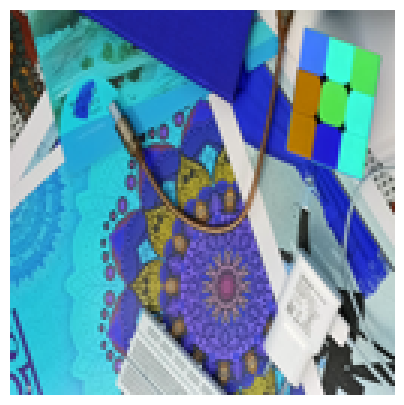

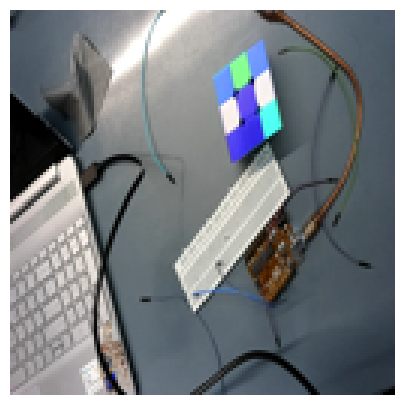

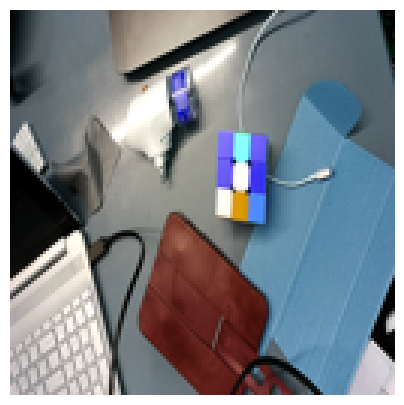

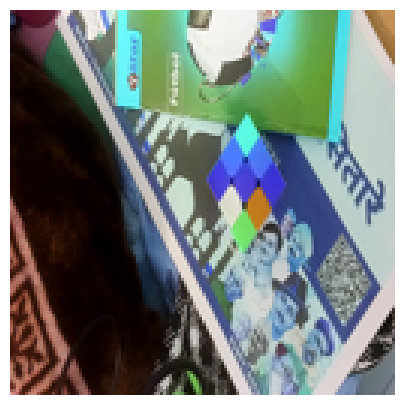

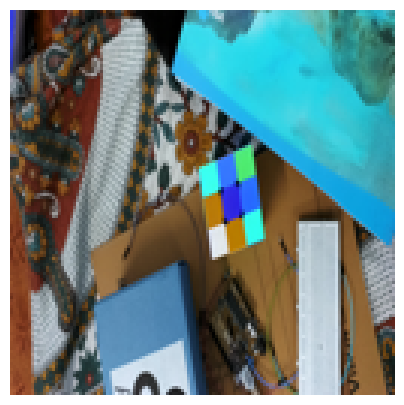

In [23]:
import cv2

def plot_random_images(images, num_samples=5):
    indices = random.sample(range(len(images)), num_samples)
    
    for idx in indices:
        image = images[idx]

        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


# Plot 5 random images
plot_random_images(images, num_samples=5)

In [24]:
def split_dataset(images, bboxes, test_size=0.2, val_size=0.1):
    """
    Splits the dataset into training, validation, and testing sets.
    
    Args:
        images (np.array): Array of images.
        bboxes (np.array): Array of bounding boxes.
        test_size (float): Proportion of the dataset to include in the test split.
        val_size (float): Proportion of the dataset to include in the validation split.
        
    Returns:
        tuple: Training, validation, and testing sets.
    """
    # First split into train+val and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        images, bboxes, test_size=test_size, random_state=42
    )
    
    # Then split train+val into train and val
    val_relative_size = val_size / (1 - test_size)  # Adjust validation size
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_size, random_state=42
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

In [25]:
# Split the dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(images, bboxes, test_size=0.2, val_size=0.1)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 691
Validation samples: 99
Testing samples: 198


In [26]:
def build_model(input_shape=(128, 128, 3)):
    """
    Builds a simple CNN model for bounding box regression.
    
    Args:
        input_shape (tuple): Shape of the input images.
        
    Returns:
        tensorflow.keras.Model: Compiled CNN model.
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='sigmoid')  # Output layer with sigmoid for normalized values
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model

In [27]:
# Build the model
model = build_model(input_shape=(128, 128, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [28]:
# Define early stopping to prevent overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
22/22 [==============================] - 10s 455ms/step - loss: 0.0195 - mae: 0.1047 - val_loss: 0.0137 - val_mae: 0.0865
Epoch 2/100
22/22 [==============================] - 9s 431ms/step - loss: 0.0122 - mae: 0.0792 - val_loss: 0.0079 - val_mae: 0.0672
Epoch 3/100
22/22 [==============================] - 10s 475ms/step - loss: 0.0061 - mae: 0.0576 - val_loss: 0.0050 - val_mae: 0.0540
Epoch 4/100
22/22 [==============================] - 9s 395ms/step - loss: 0.0036 - mae: 0.0437 - val_loss: 0.0036 - val_mae: 0.0449
Epoch 5/100
22/22 [==============================] - 9s 398ms/step - loss: 0.0024 - mae: 0.0366 - val_loss: 0.0027 - val_mae: 0.0384
Epoch 6/100
22/22 [==============================] - 8s 379ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0028 - val_mae: 0.0396
Epoch 7/100
22/22 [==============================] - 9s 390ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0023 - val_mae: 0.0359
Epoch 8/100
22/22 [==============================] - 9s 395ms/step 

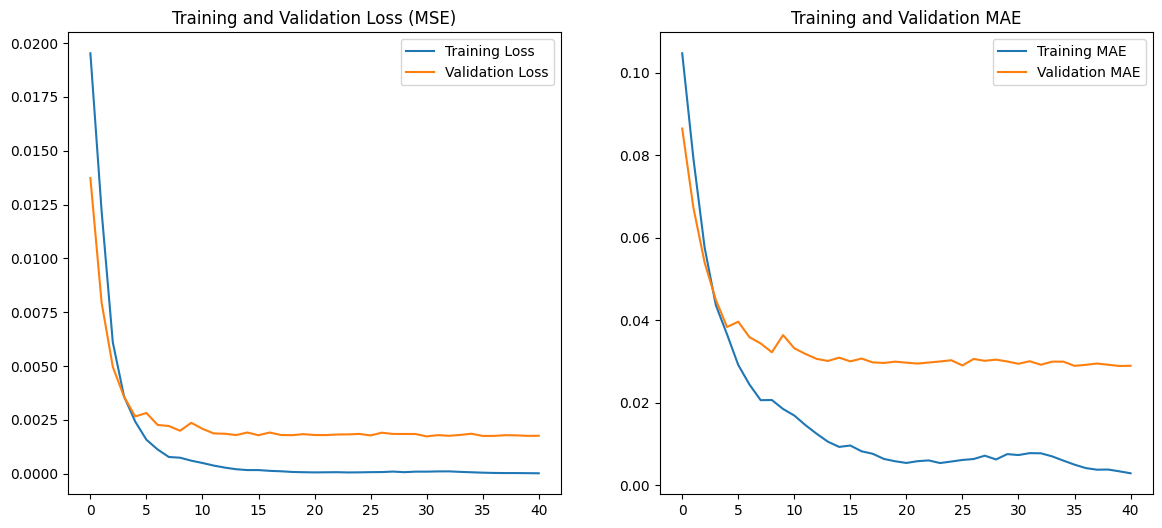

In [29]:
def plot_history(history):
    """
    Plots training and validation loss and MAE over epochs.
    
    Args:
        history (tf.keras.callbacks.History): History object from model training.
    """
    acc = history.history['mae']
    val_acc = history.history['val_mae']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs_range = range(len(acc))
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss (MSE)')
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, acc, label='Training MAE')
    plt.plot(epochs_range, val_acc, label='Validation MAE')
    plt.legend(loc='upper right')
    plt.title('Training and Validation MAE')
    
    plt.show()

# Plot the training history
plot_history(history)

In [30]:
# Save the model
model.save('rubiks_cube_detector_v2.h5')
print("Model saved to 'rubiks_cube_detector_v2.h5'")

Model saved to 'rubiks_cube_detector_v2.h5'


/Users/ludvigeriksonbrangstrup/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [31]:
# Make predictions on the test set
predictions = model.predict(X_test)

# Ensure predictions are in the range [0,1] due to sigmoid activation
predictions = np.clip(predictions, 0, 1)

print(f"Made predictions on {len(predictions)} test samples.")

7/7 [==============================] - 1s 96ms/step
Made predictions on 198 test samples.


In [32]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each bounding box parameter
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Absolute Error (MAE) on Test Set: {mae:.4f}")

Mean Absolute Error (MAE) on Test Set: 0.0336


In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_prediction(image, true_bbox, pred_bbox, img_size=(128, 128)):
    """
    Visualizes the true and predicted bounding boxes on the image.
    
    Args:
        image (np.array): The image array.
        true_bbox (list or np.array): True bounding box [x_center, y_center, width, height].
        pred_bbox (list or np.array): Predicted bounding box [x_center, y_center, width, height].
        img_size (tuple): Size of the image (width, height).
    """
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(image)
    
    # Function to convert center coordinates to corner coordinates
    def center_to_corner(box):
        x_center, y_center, width, height = box
        x_min = (x_center - width / 2) * img_size[0]
        y_min = (y_center - height / 2) * img_size[1]
        return [x_min, y_min, width * img_size[0], height * img_size[1]]
    
    # True Bounding Box (Green)
    true_box = center_to_corner(true_bbox)
    rect_true = patches.Rectangle(
        (true_box[0], true_box[1]),
        true_box[2],
        true_box[3],
        linewidth=2,
        edgecolor='g',
        facecolor='none',
        label='True BBox'
    )
    ax.add_patch(rect_true)
    
    # Predicted Bounding Box (Red)
    pred_box = center_to_corner(pred_bbox)
    rect_pred = patches.Rectangle(
        (pred_box[0], pred_box[1]),
        pred_box[2],
        pred_box[3],
        linewidth=2,
        edgecolor='r',
        facecolor='none',
        label='Predicted BBox'
    )
    ax.add_patch(rect_pred)
    
    plt.legend()
    plt.axis('off')
    plt.show()

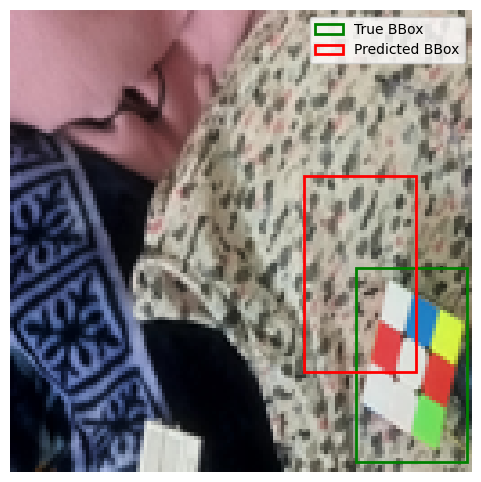

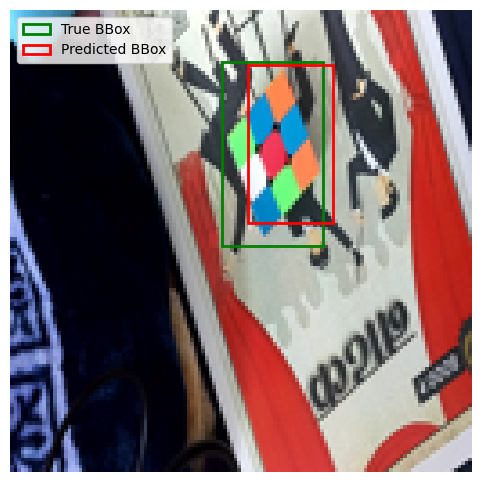

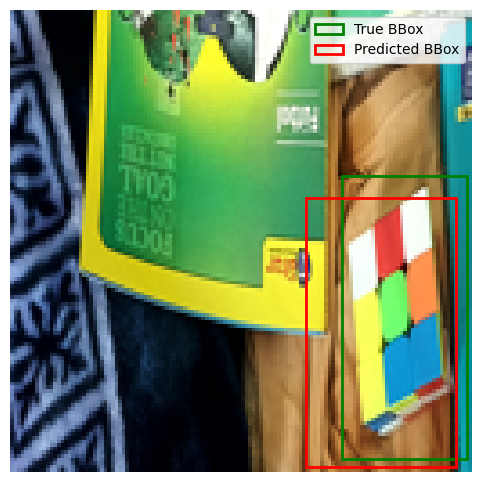

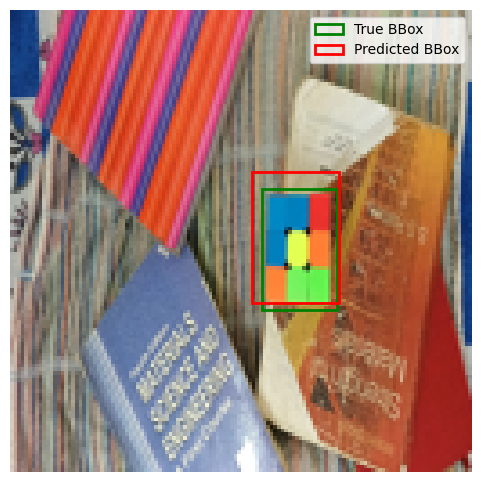

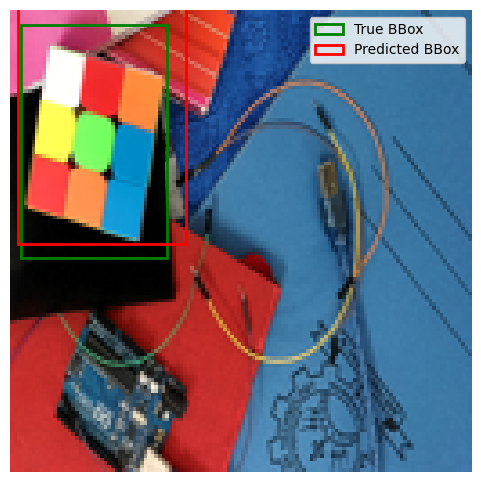

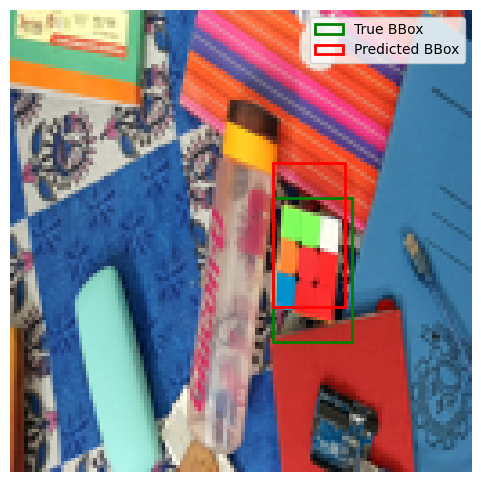

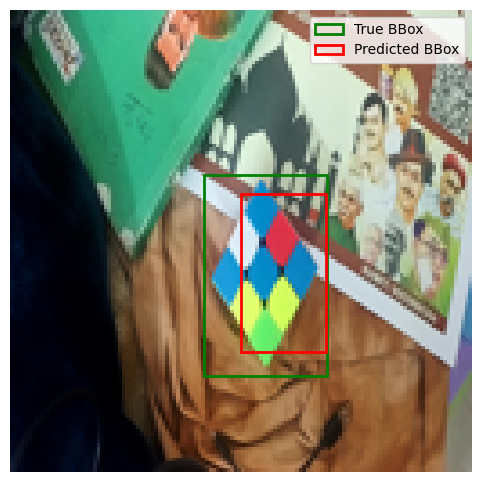

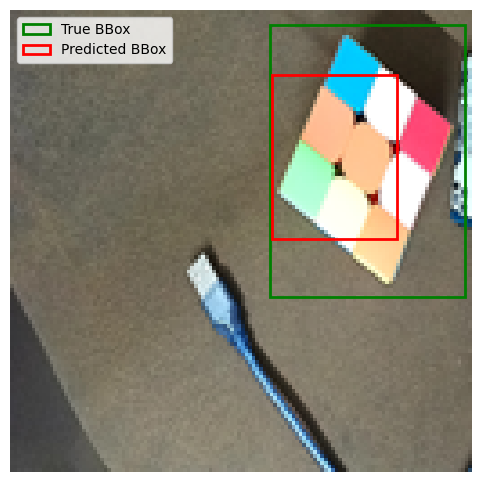

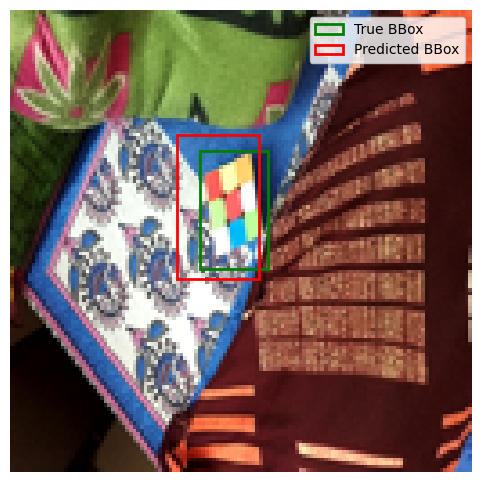

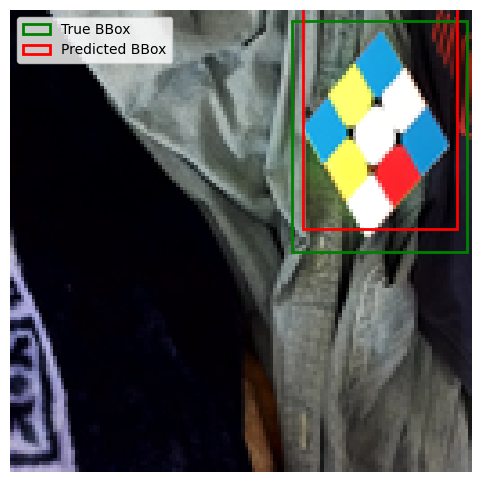

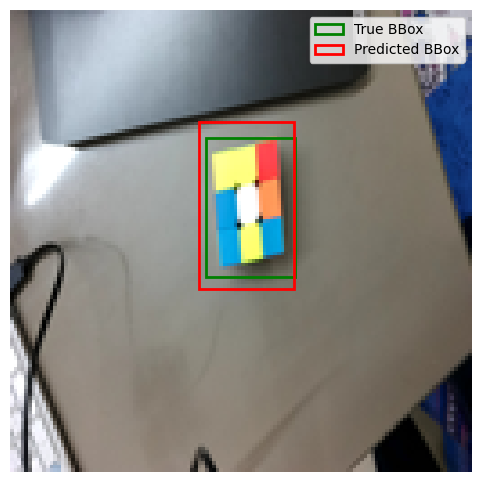

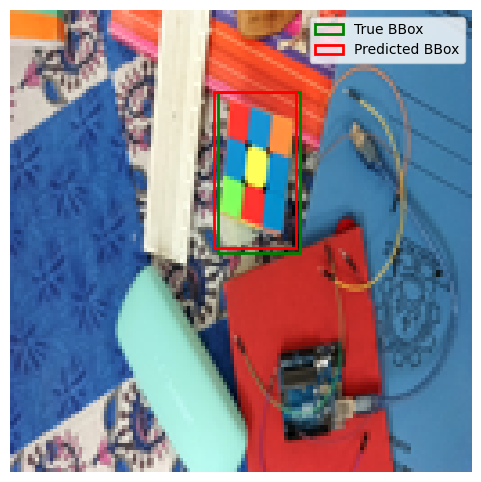

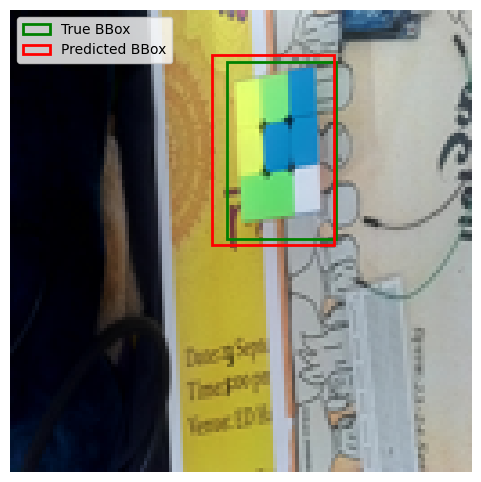

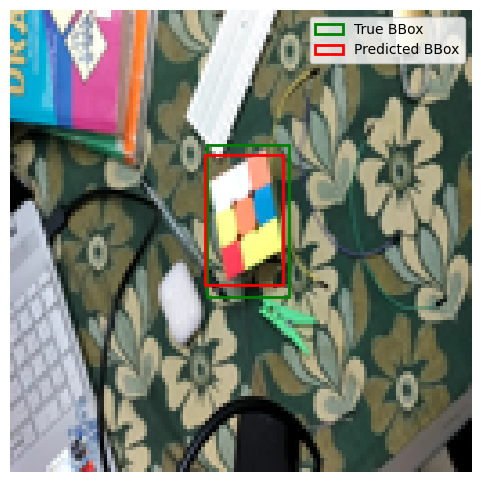

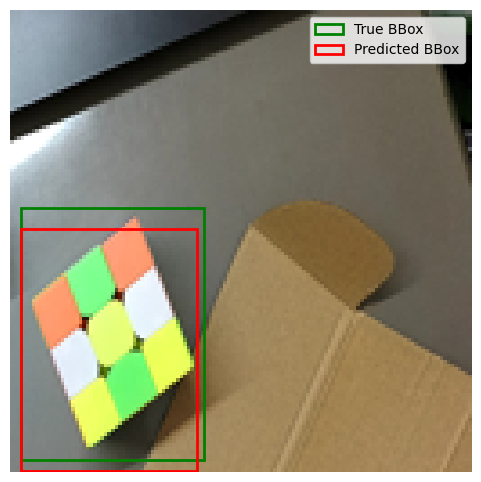

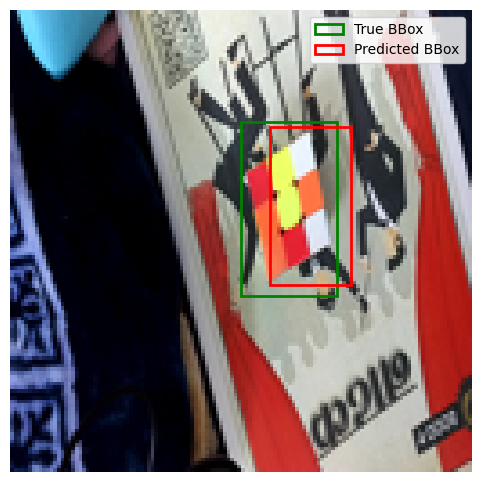

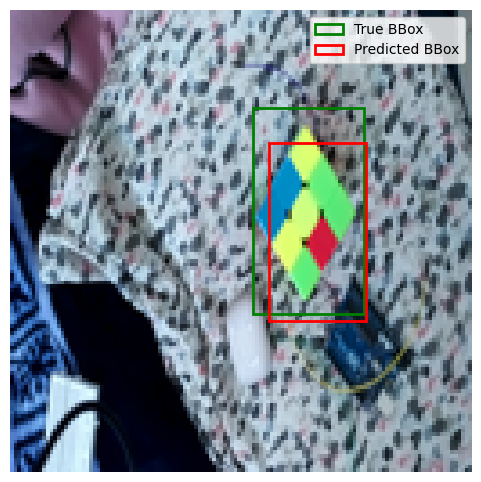

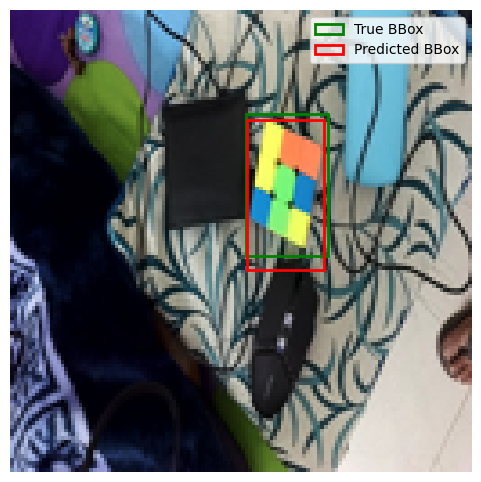

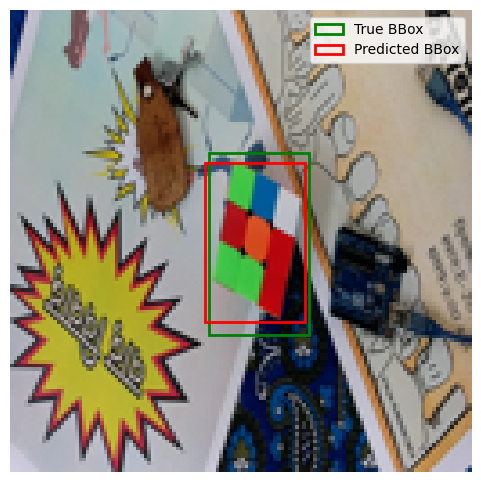

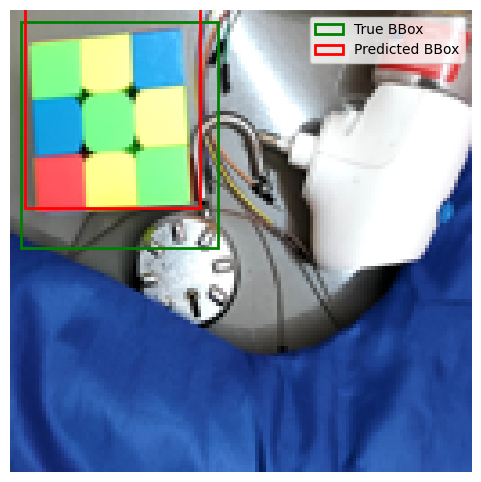

In [34]:
import random

def visualize_multiple_predictions(X, y_true, y_pred, num_samples=5, img_size=(128, 128)):
    """
    Visualizes multiple predictions with their true bounding boxes.
    
    Args:
        X (np.array): Array of images.
        y_true (np.array): Array of true bounding boxes.
        y_pred (np.array): Array of predicted bounding boxes.
        num_samples (int): Number of samples to visualize.
        img_size (tuple): Size of the image (width, height).
    """
    indices = random.sample(range(len(X)), num_samples)
    
    for idx in indices:
        image = X[idx]
        true_bbox = y_true[idx]
        pred_bbox = y_pred[idx]
        visualize_prediction(image, true_bbox, pred_bbox, img_size=img_size)

# Visualize predictions
visualize_multiple_predictions(X_test, y_test, predictions, num_samples=20, img_size=(128, 128))